<a href="https://colab.research.google.com/github/uncbiag/OAI_analysis_2/blob/main/notebooks/FullDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
# Remember to Restart runtime after installation

!pip install vtk
!pip install itkwidgets
!pip install itk
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install icon-registration==0.3.4
!git clone https://github.com/uncbiag/OAI_analysis_2

In [ ]:
import numpy as np
import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

# Remove this once the pip package is available
import sys
sys.path.append("./OAI_analysis_2/")
import oai_analysis
import oai_analysis.mesh_processing as mp
from oai_analysis.analysis_object import AnalysisObject

# To enable running the itkwidgets window on colab
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib inline

In [ ]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

Local metadata does not exists. Falling back to download.
[####################################]  74.74M/74.74M  100%  atlas_image.nii.gz          
[####################################]  76.70M/76.70M  100%  FC_probmap.nii.gz          
[####################################]  27.96M/27.96M  100%  image_preprocessed.nii.gz          
[####################################]  76.66M/76.66M  100%  TC_probmap.nii.gz          


In [ ]:
import os
import sys

test_volume = itk.imread(os.path.join("OAIData", "image_preprocessed.nii.gz"))

obj = AnalysisObject()
FC_prob, TC_prob = obj.segment(test_volume)

segmenter_config created
Loading parameter file = OAI_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint 'OAI_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint 'OAI_analysis_2/data/segmentation_model.pth.tar' (epoch 600)


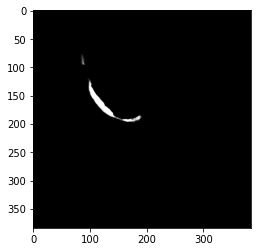

In [ ]:
# Visualize the segmented FC probability map

plt.imshow(FC_prob[85], cmap='gray')

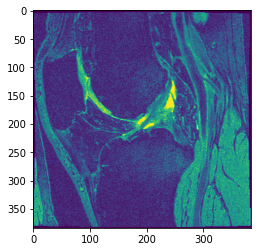

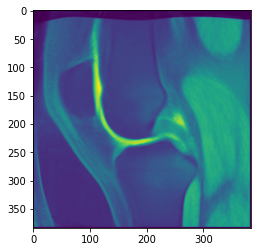

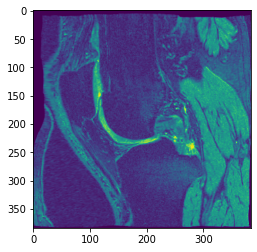

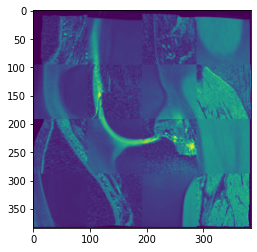

In [ ]:
# Register the Atlas and the given image

model = pretrained_models.OAI_knees_registration_model()

image_A = itk.imread("./OAIData/image_preprocessed.nii.gz", itk.D)
image_B = itk.imread("./OAIData/atlas_image.nii.gz", itk.D)


# Register the images
phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

interpolator = itk.LinearInterpolateImageFunction.New(image_A)
warped_image_A = itk.resample_image_filter(image_A, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


# Plot the images to check the alignment
checker_board = itk.checker_board_image_filter(warped_image_A, image_B)

plt.imshow(image_A[80])
plt.show()
plt.imshow(image_B[80])
plt.show()

plt.imshow(warped_image_A[80])
plt.show()

plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[80])
plt.show()

In [ ]:
# For deforming the FC and TC probability images using the transform obtained after registration

warped_image_FC = itk.resample_image_filter(FC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


warped_image_TC = itk.resample_image_filter(TC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

print(warped_image_FC.shape)
print(warped_image_TC.shape)

(160, 384, 384)
(160, 384, 384)


In [ ]:
# Get the thickness map for the meshes

distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


In [ ]:
# Get inner and outer meshes for the TC and FC atlas meshes

prob_fc_atlas = itk.imread('./OAIData/atlas_fc.nii.gz')
mesh_fc_atlas = mp.get_mesh(prob_fc_atlas)
inner_mesh_fc_atlas, outer_mesh_fc_atlas = mp.split_mesh(mesh_fc_atlas, mesh_type='FC')

prob_tc_atlas = itk.imread('./OAIData/atlas_tc.nii.gz')
mesh_tc_atlas = mp.get_mesh(prob_tc_atlas)
inner_mesh_tc_atlas, outer_mesh_tc_atlas = mp.split_mesh(mesh_tc_atlas, mesh_type='TC')

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


In [ ]:
# For mapping the thickness to the atlas mesh

mapped_mesh_fc = mp.map_attributes(distance_inner_FC, inner_mesh_fc_atlas)
mapped_mesh_tc = mp.map_attributes(distance_inner_TC, inner_mesh_tc_atlas)

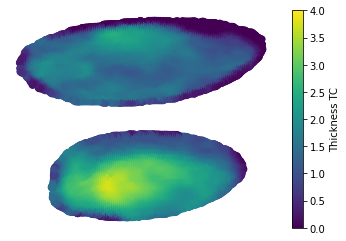

In [ ]:
# Plot the 2D Thickness projection for TC

mesh_type = 'TC'
x, y, t = mp.project_thickness(mapped_mesh_tc, mesh_type=mesh_type)

s = plt.scatter(x, y, c=t, vmin=0, vmax=4)
cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()

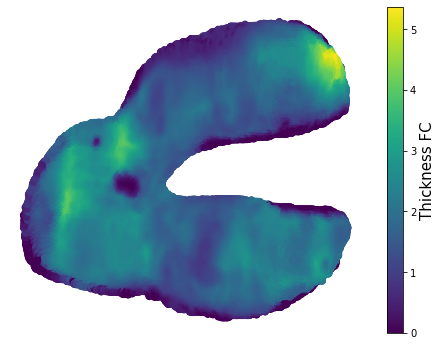

In [ ]:
# Plot the 2D Thickness projection for FC

mesh_type = 'FC'
x, y, t = mp.project_thickness(mapped_mesh_fc, mesh_type=mesh_type)

plt.figure(figsize=(8, 6))

s = plt.scatter(x, y, c=t)

cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type, size=15)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()

In [ ]:
# Visualize the thickness map

view(geometries=[distance_inner_TC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# Visualize the thickness map

view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…